In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import plotly.express as px
import networkx as nx
import degroot as dg
from tqdm import tqdm
import plotly.graph_objects as go
from joblib import Parallel, delayed

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Parameters
dims = 8
erdos_reni_p = 0.5
n_initial_conditions_attempts = 100
max_edge_value = 1
correct_belief = 0.9
init_belief = np.random.uniform(0, 1, size=dims)
niter_degroot = 2
niter_search = 10_000
symmetric = False

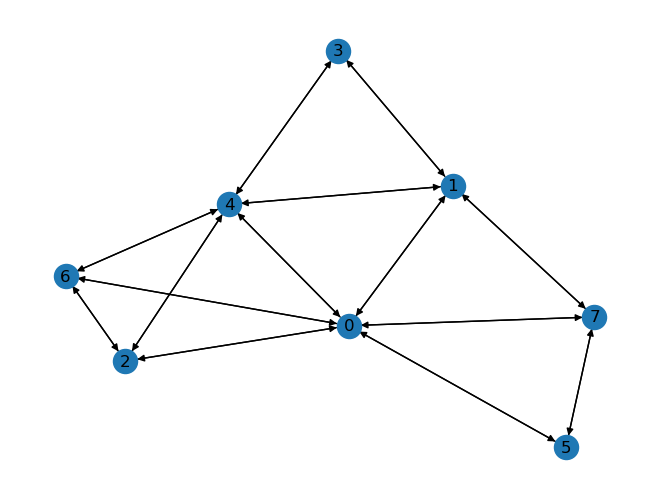

In [4]:
m_base = nx.adjacency_matrix(nx.erdos_renyi_graph(n=dims, p=erdos_reni_p)).todense()
while np.min(np.sum(m_base, axis=0)) == 0 or np.max(np.sum(m_base, axis=1)) == dims-1:
    m_base = nx.adjacency_matrix(nx.erdos_renyi_graph(n=dims, p=erdos_reni_p)).todense()
nx.draw(nx.from_numpy_array(m_base, create_using=nx.DiGraph), with_labels=True)

In [17]:
correct_belief = 0.5

In [18]:
dg.degroot_err(m_base, init_belief, correct_belief, niter_degroot)

(0.05501831629489118,
 array([0.52617779, 0.55850007, 0.52123538, 0.57352998, 0.58211312,
        0.51847566, 0.60149931, 0.55861522]))

In [19]:
rewiring_sample = dg.get_rewiring_sample(m_base, n_rewiring_attempts=10_000)

In [20]:
peaks = dg.find_local_peaks(sample=rewiring_sample, initial_belief=init_belief, correct_belief=correct_belief, niter_degroot=niter_degroot)

100%|██████████| 10000/10000 [00:02<00:00, 3443.25it/s]


In [21]:
error = []
for p in peaks:
    error.append({'error': p['error'], 'estimate': p['estimate']})
    
error = pd.DataFrame(error)
hist, bins = np.histogram(error['estimate'], bins=100)
print(np.std(error['estimate']))
px.bar(x=bins[1:], y=hist)

0.0002404128337329329


In [22]:
print('Unique peaks', len(np.unique([p['m'].flatten() for p in peaks], axis=0)))

Unique peaks 9951
